© 2018 Suzy Beeler and Vahe Galstyan. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This exercise was generated from a Jupyter notebook. You can download the notebook [here](gene_expression_master_equation.ipynb).
___

# Objective 

We've [previously](diffusion_master_equation.html) used a chemical master equation to describe diffusion. Here we, will take a similar approach to describe the evolution of mRNA counts of time as the result of constitutive gene expression. Lastly, we will show that the steady state solution takes on the form of a Poisson distribution. 

# Master equation for constitutive gene expression

As we derived in class, the master equation that describes the stochastic dynamics of mRNA counts is

\begin{align}
\overbrace{p(m, t+ \Delta t)}^{\text{new probability}} = 
\underbrace{p(m, t))}_{\text{old probability}} + 
\overbrace{r \Delta t \, p(m-1, t)}^{\text{production from lower state}} + 
\underbrace{\gamma (m+1) \Delta t \, p(m+1, t)}_{\text{degradation from upper state}} - 
\overbrace{r \Delta t \, p(m,t)}^{\text{production out of this state}} - 
\underbrace{\gamma m \Delta t \, p(m,t)}_{\text{degradation out of this state}}, \tag{1}
\end{align}

where $p(m,t)$ is the probability that the cell has $m$ mRNAs at time $t$, $r$ is the rate of constitutive expression, $\gamma$ is the mRNA degradation rate and $\Delta t$ is the time increment that we'll use in numerical estimation.

Like in [the case of diffusion](diffusion_master_equation.html), here too we need to specify the boundary conditions for the master equation, namely

\begin{align}
\overbrace{p(0, t+ \Delta t)}^{\text{new probability}} = 
\underbrace{p(0, t)}_{\text{old probability}} + 
\overbrace{\gamma \Delta t p(1, t)}^{\text{degradation from upper state}} - 
\underbrace{r \Delta t \, p(0,t)}_{\text{production out of this state}} \tag{2}
\end{align}

for $m=0$ (where we aren't allowed to have any degradation) and

\begin{align}
\overbrace{p(M, t+ \Delta t)}^{\text{new probability}} = 
\underbrace{p(M, t)}_{\text{old probability}} + 
\overbrace{r \Delta t \, p(M-1, t)}^{\text{production from lower state}} -
\underbrace{\gamma M \Delta t \, p(M,t)}_{\text{degradation out of this state}}, \tag{3}
\end{align}

for the $m=M$, the largest number of mRNAs that we will allow, since can only simulate a finite number of possible mRNA counts. In practice, choosing a value for $M$ that is several times larger than the mean number of mRNAs will be sufficient to ensure accurate estimates.

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# for plots
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(rc=rc)

# import utilites to 3D plots
import pboc_utilities as pboc

We begin by assigning numerical values to the parameters of the model and initialize the distribution to have one mRNA at $t=0$. For our choice of parameters, the average number of mRNAs should be $\frac{r}{\gamma} = 5$.

In [2]:
# time step
dt = 0.1 # min

# mRNA production rate
r = 0.5 # min^-1

# degradation rate
gamma = 0.1 # min^-1

# max number of mRNAs we will compute probabilities for
M = 20

# number of steps
n_steps = 500

# array to store mRNA probabilities
mRNA = np.zeros([M, n_steps])

# probability at t=0
mRNA[0,0] = 1

We then follow the standard numerical integration procedure to obtain the distribution of mRNA counts at different points in time.

In [3]:
# loop through time
for t in range(1,n_steps):
    
    # update the mRNA counts for 1 through M-1
    for m in range(1, M-1):
        mRNA[m, t] = mRNA[m,t-1] + r*dt*mRNA[m-1,t-1] + gamma*(m+1)*dt*mRNA[m+1,t-1] \
                       - r*dt*mRNA[m,t-1] - gamma*m*dt*mRNA[m,t-1]
    
    # Left boundary
    mRNA[0,t] = mRNA[0,t-1] + gamma*dt*mRNA[1,t-1] - r*dt*mRNA[0,t-1]
    
    # Right boundary
    mRNA[-1, t] = mRNA[-1, t-1] + r*dt*mRNA[-2,t-1]-gamma*(M-1)*dt*mRNA[-1,t-1]

Finally, we use the utility function `bar_plot` to display the probability distribution at different instances.

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1c19ebfbe0>)

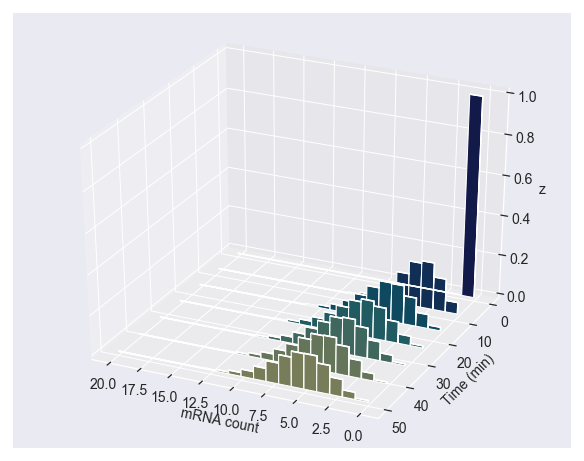

In [4]:
pboc.bar_plot(mRNA, n_slices=6, dy=dt, x_label='mRNA count', y_label='Time (min)')

As we can see, the distribution of mRNA counts converges into a Poisson distribution. To further verify this, we can plot the known Poission distribution on top of our mRNA counts distribution. 

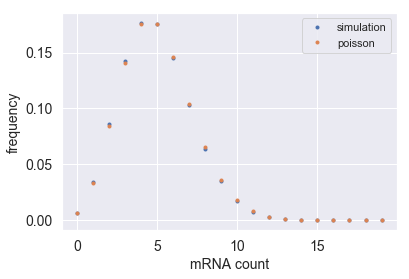

In [5]:
# plot our last time point mRNA distribution
plt.plot(mRNA[:,-1], '.')
plt.xlabel("mRNA count")
plt.ylabel("frequency")

# plot poisson distribution on top
# randgs of mRNA counts to plot over
n_mRNAs = np.arange(M)

# lambda, rate of "success"
lam = r/gamma

# use scipy's built in poisson pmf
poisson_dist = (stats.poisson.pmf(n_mRNAs,lam))

# plot
plt.plot(poisson_dist,'.')
plt.legend(["simulation","poisson"])

Viola! We see that the steady state solution of our simulation is in fact Poisson distributed. 